In [2]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os as os
import nrrd as reader
import pandas as pd
import cv2 
import csv
from tqdm import tqdm
from tabulate import tabulate
from skimage import morphology
from skimage import measure
from skimage import segmentation
from skimage.segmentation import flood, flood_fill
from skimage.measure import label
from skimage.segmentation import active_contour
from skimage import data, io, img_as_ubyte,filters
from time import sleep
from IPython.display import clear_output

In [3]:
def join(one, two):
    return os.path.join(one, two)

def check_path(path):
    count=0
    for files in sorted(os.listdir(path)):
        image_path = os.path.join(path,files)
        count+=1
    return count

num_patients =check_path(join(os.getcwd(), "dataset"))
folder_path=join(os.getcwd(), "dataset")

for patient in sorted(os.listdir(folder_path)):
    patient_path = join(folder_path, patient)
    InputImage=sitk.ReadImage(sitk.ImageSeriesReader_GetGDCMSeriesFileNames(patient_path)) 
    inputs = np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1]), 1))
    
slicesperpatient=InputImage.GetSize()[2]
totalslices=(num_patients * InputImage.GetSize()[2])
slicesperpatient=InputImage.GetSize()[2]
print(f'{num_patients} Patient File(s) Found. Total MR Slices Found: {totalslices} Slices / Patient: {slicesperpatient}')

134 Patient File(s) Found. Total MR Slices Found: 2010 Slices / Patient: 15


In [115]:
def dcm_to_np(path):
    global dic_count
    global patient_count
    try:
        slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path)
        image = sitk.ReadImage(slice_filenames)
        for x in range(15):
            current_slice = image[:, :, x]
            current_array = sitk.GetArrayFromImage(current_slice)
            split_array = current_array[:,:-256]
            inputs[dic_count] = split_array[:, :, np.newaxis]
        print("Importing...")
        print(f'{patient} {patient_count}/{num_patients}')
        print("_____________________________")
    except Exception as e:
        print(e)

dic_count = 0
patient_count = 0
try:
    for patient in sorted(os.listdir(folder_path)):
        clear_output(wait=True)
        patient_path = join(folder_path, patient)
        dcm_to_np(patient_path)
        patient_count+=1
        dic_count+=1
    clear_output(wait=True)
    print("Import Complete.")
    print(f'{patient_count} Patient DCM(s) found.')
except Exception as e:
    print(e)        

Import Complete.
134 Patient DCM(s) found.


In [10]:
def bgrm(inputs):
    if inputs.ndim > 2:
        inputs=inputs[:,:,:,0]
    MRBasicMask=np.where(inputs>inputs.mean(),1,0)
    MRBasicMask=morphology.binary_closing(MRBasicMask)
    MRBasicMask=morphology.binary_opening(MRBasicMask)
    try:
        for x in range (inputs.shape[0]):
            labelled = morphology.label(MRBasicMask[x])
            rp = measure.regionprops(labelled)
            # get size of largest cluster
            size = max([i.area for i in rp])
            # remove everything smaller than largest
            MRBasicMask[x] = morphology.remove_small_objects(labelled, min_size=size-1)
            MRBasicMask[x] = morphology.convex_hull_object(MRBasicMask[x])

    except TypeError:
        print(f'{TypeError} iteration #{x}')
    except UserWarning:
        print(f'{UserWarning} iteration #{x}')
    return MRBasicMask

In [117]:
def normalization(array):
    corrected_array=np.zeros(array.shape)
    for i in range (array.shape[0]):
        corrected_array[i] = cv2.normalize(src=array[i], dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) #need to normalize, not direct conversion by "np.uint8"
    return corrected_array

nminput=normalization(inputs[:,:,:,0])


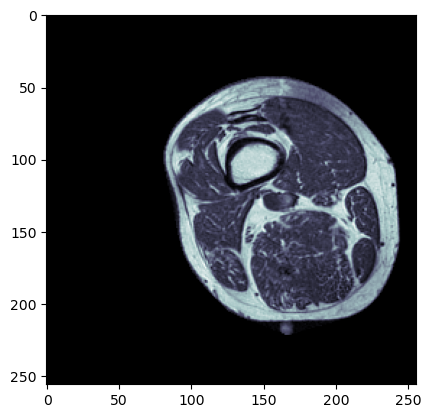

In [122]:
plt.imshow(nminput[2000],'bone')

In [184]:
def N4BFC(array):
    t=tqdm(total=array.shape[0])
    inputarray=np.zeros(array.shape)
    for i in range (inputarray.shape[0]):
        image = sitk.GetImageFromArray(array[i])
        corrected_image = sitk.N4BiasFieldCorrection(image)
            # corrected_image = sitk.N4BiasFieldCorrection(corrected_image)
        inputarray[i] = sitk.GetArrayFromImage(corrected_image)
        t.update(1)
        elapsed = t.format_dict["elapsed"]
        rate = t.format_dict["rate"]
        remaining = (t.total - t.n) / rate if rate and t.total else 0 # Seconds*
    return inputarray


In [185]:
corrected=N4BFC(nminput) 

100%|██████████| 2010/2010 [11:11<00:00,  2.99it/s] 


In [188]:
corrected2=N4BFC(corrected)

100%|██████████| 2010/2010 [08:35<00:00,  3.90it/s]


In [192]:
corrected3=N4BFC(corrected2)

100%|██████████| 2010/2010 [07:17<00:00,  4.60it/s]


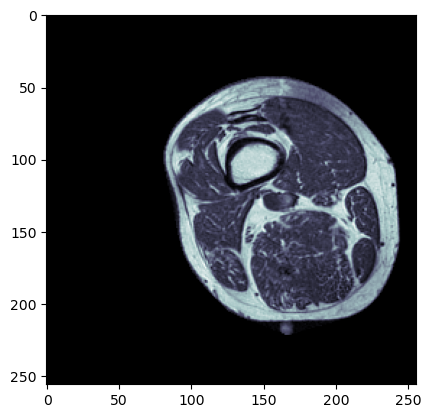

In [172]:
plt.imshow(inputs[2000],'bone',vmin=0,vmax=255)

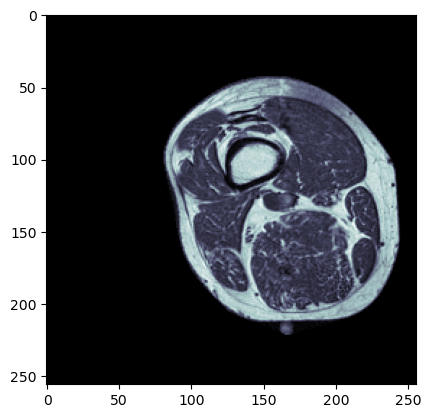

In [174]:
plt.imshow(corrected2[2000],'bone',vmin=0,vmax=255)

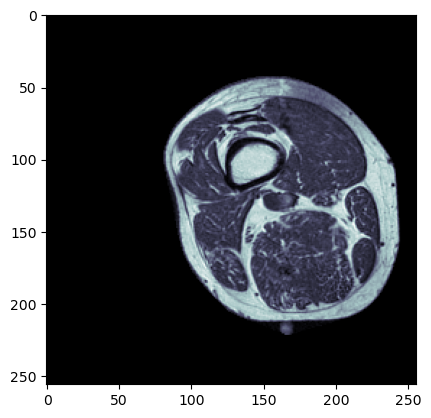

In [193]:
plt.imshow(corrected3[2000],'bone',vmin=0,vmax=255)

 fig, axs=plt.subplots (1,3, figsize=(15,10))
        axs[0].imshow(Array[i],"bone")
        axs[0].set_title(f'{ArrayN} {s}')
        axs[0].axis("off")
        axs[1].imshow(Array1[i],"bone")
        axs[1].set_title(f'{ArrayN1} {s}')
        axs[1].axis("off")

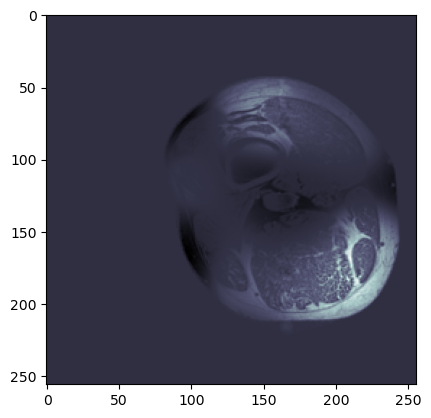

In [189]:
plt.imshow(corrected2[2000]-corrected[2000],'bone')

In [191]:
diff = (corrected2[2000]-nminput[2000]).sum()
print(diff)

24504.60446452166


In [194]:
diff = (corrected3[2000]-nminput[2000]).sum()
print(diff)

32464.46787785264


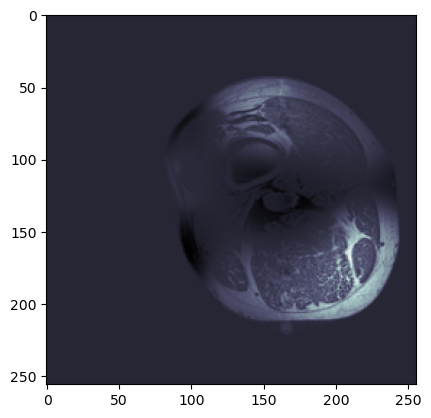

In [ ]:
plt.imshow(corrected[2000]-nminput[2000],'bone')

In [187]:
a = (corrected[2000]-nminput[2000]).sum()
print(a)

14808.256735470288


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([46797.38975313, 46797.48975313, 46797.58975313, 46797.68975313,
        46797.78975313, 46797.88975313, 46797.98975313, 46798.08975313,
        46798.18975313, 46798.28975313, 46798.38975313]),
 <BarContainer object of 10 artists>)

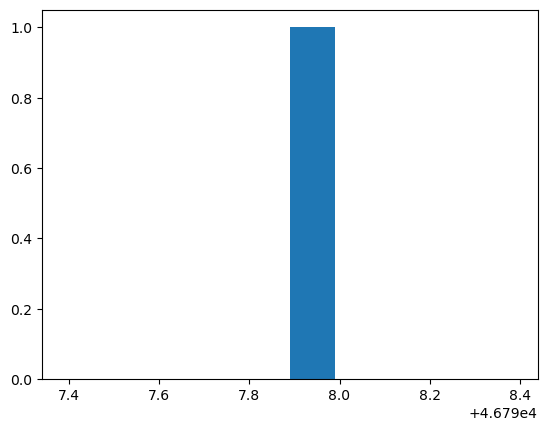

In [178]:
plt.hist(a)

In [177]:
7865.442466370881-6467.979408902007


1397.4630574688745

In [179]:
np.save("N4BFC.npy",corrected2)

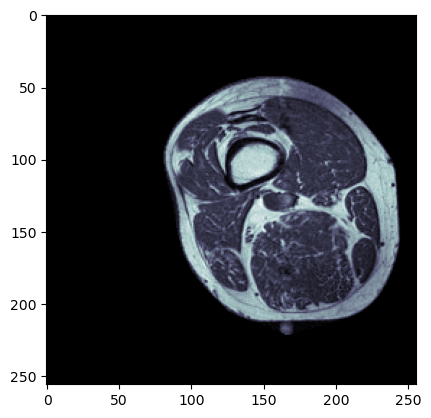

In [113]:
plt.imshow(cleanimage[2000],'bone')